# Time Series Analysis of Monthly Airline Passengers (1949–1960)

**Objective:** Analyze trends, seasonality, and forecasting patterns in the monthly international airline passengers dataset to derive actionable insights and apply time series modeling techniques.

In [194]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'  # Configure Plotly to display figures in the notebook
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller (ADF) test
from statsmodels.tsa.stattools import kpss # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

from statsmodels.tsa.arima.model import ARIMA


We load the dataset and parse the 'Month' column as datetime, and check for the Na values.


In [212]:
df = pd.read_csv("AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [213]:
df.isna().sum()

Month          0
#Passengers    0
dtype: int64

In [214]:
df['Month'] = pd.to_datetime(df['Month'], format = '%Y-%m')
df.rename(columns = {'Month' : 'Date', '#Passengers' : 'Passengers' }, inplace=True)
df.head()

,Date,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


### Monthly Passenger Trend (1949–1960)

The interactive line chart below visualizes the monthly number of international airline passengers from 1949 to 1960. This visualization allows us to:

- Identify long-term trends,
- Observe seasonal patterns,
- Detect periods of accelerated or reduced growth.


In [215]:
fig = px.line(df, x = 'Date', y = 'Passengers', title = 'Number of Airline Passengers Over Time')
fig.show()

### Stationarity
Stationarity is an important concept in time series analysis because many useful analytical tools and statistical tests and models rely on it. Stationarity means that the statistical properties such as mean, variance, covariance, and standard deviation do not vary with time, or these statistical properties are not a function of time.  

#### For a stationary series,
- The mean is constant over time,
- The variance is constant over time (no increasing or decreasing spread)
- the autocorrelation depends only on the lag, not on the actual time points.


We observe a consistent upward trend over the years, along with strong seasonal fluctuations—typically peaking during July and August. Therefore, it can be said that the time series is not stationary. 

To make the time series stationary we use:

-**First Differencing** to remove the long-term increasing pattern,

-**Log Transformation** to stabilize variance by compressing higher values more than lower ones.


In [216]:
df['Passenger_Diff'] = df['Passengers'].diff()
fig = px.line(df, x = 'Date', y = 'Passenger_Diff',
              labels = {'Date':'Date', 'Passenger_Diff' : 'Passengers<br>Difference Transform'},
              title = 'Airline Passengers'
             )
fig.show()

As we can see now there is no increasing trend and the mean of the data is around zero. However the variance is still changing. Therefore we need the log transformation.

In [217]:
df['Passenger_log'] = np.log(df['Passengers'])
fig = px.line(df, x = 'Date', y = 'Passenger_log',
              labels = {'Date':'Date', 'Passenger_log' : 'Passengers<br>Log Transform'},
              title = 'Airline Passengers'
             )
fig.show()

After logarithm transform we can see that the fluctuations are now consistent. Now we again apply the difference transform.

In [218]:
df['Passengers_dif_log'] = df['Passenger_log'].diff()
fig = px.line(df, x = 'Date', y = 'Passengers_dif_log',
              labels = {'Date':'Date', 'Passengers_dif_log' : 'Passengers<br>Log and Difference Transform'},
              title = 'Airline Passengers'
             )
fig.show()

## Stationarity Test

As we can observe now the time series now does not show the increasing trend and the variance also seems constant. However, we can use quantitative techniques to determine if the data is indeed stationary. One such technique is **Augmented Dicky-Fuller (ADF) test**. The test has a null hypothesis that the data has a unit root, which means it’s not stationary. 

In [219]:
adf = adfuller(df['Passengers_dif_log'].dropna())
print(f"ADF Statistic: {adf[0]:.4f}")
print(f"p-value: {adf[1]:.4f}")
print("Critical Values:")
for key, value in adf[4].items():
    print(f"{key} : {value:.4f}")

ADF Statistic: -2.7171
p-value: 0.0711
Critical Values:
1% : -3.4825
5% : -2.8844
10% : -2.5790


With an ADF statistic of −2.71, which lies between the 10% and 5% critical values, and a p-value of 0.071, the null hypothesis of non-stationarity is rejected only at the 10% level, indicating weak evidence for stationarity.

Another method to check the stationarity is **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**. A key difference from the ADF test is the null hypothesis of the KPSS test is that the series is stationary.

In [220]:
stat, p_value, _, critical_values = kpss(df['Passengers_dif_log'].dropna())
print(f"KPSS Statistic: {stat:4f}")
print(f"p_value: {p_value:4f}")
print("critical values")
for key, value in critical_values.items():
    print(f"{key} : {value:.4f}")

KPSS Statistic: 0.038304
p_value: 0.100000
critical values
10% : 0.3470
5% : 0.4630
2.5% : 0.5740
1% : 0.7390


C:\Users\arefe\AppData\Local\Temp\ipykernel_25188\1597639557.py:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




As we can see, the test statistic is very small and lies below all critical values. In addition, the p-value is very large. Therefore, we conclude that the null hypothesis of a stationary series is not rejected at any conventional significance level.

The next step is to select a model to be able to forecast the future of the time series. To do so, we first start with Auto Regressive models. To select the order of the AR model we first plot the Partial Autocorrelation

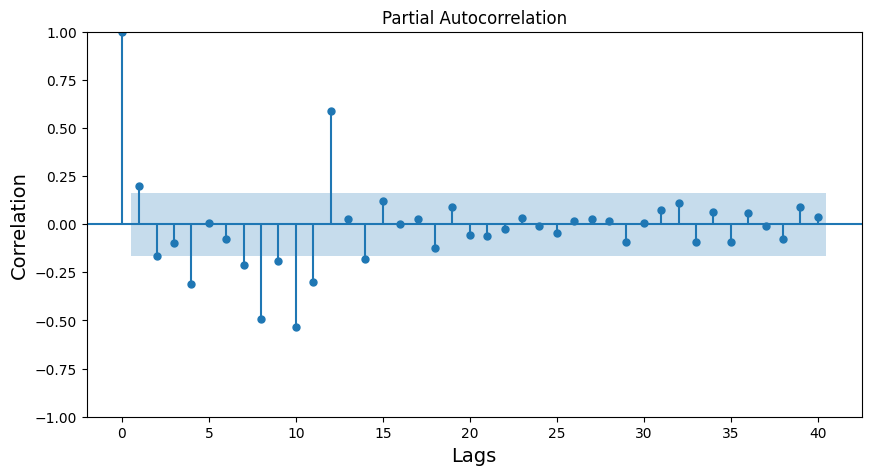

In [221]:
plt.rc("figure", figsize=(10, 5))
plot_pacf(df['Passengers_dif_log'].dropna(), lags = 40)
plt.xlabel('Lags', fontsize = 14)
plt.ylabel('Correlation', fontsize = 14)
plt.show()

From this plot it can be observed that lags 1, 2, 4, 7, 8, 9, 10, 11, 12 and 14 are significant. Here we use the statsmodels ar_select_order to determine the optimal number of lags to include in the autoregressive model. In this case, we have set our model to try combinations up to lag 15.

In [222]:
print(df.columns)


Index(['Date', 'Passengers', 'Passenger_Diff', 'Passenger_log',
       'Passengers_dif_log'],
      dtype='object')


In [ ]:
# Split train and test
df.set_index('Date', inplace=True)
df = df.asfreq('MS') # Monthly Start

In [234]:

train = df.iloc[:-int(len(df) * 0.2)]
test = df.iloc[-int(len(df) * 0.2):]

# Build AR model
selector = ar_select_order(train['Passengers_dif_log'].dropna(), 15)
model_AR = AutoReg(train['Passengers_dif_log'].dropna(), lags=selector.ar_lags).fit()
#print(model_AR.summary())

In [235]:
start = len(train)
end = len(train) + len(test) - 1
predictions_model_AR = model_AR.predict(start=start, end=end)


In [229]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

true_values = test['Passengers_dif_log'].dropna()
mse_model_AR = mean_squared_error(true_values, predictions_model_AR)
mae_model_AR = mean_absolute_error(true_values, predictions_model_AR)

print(f"MSE: {mse_model_AR:.4f}")
print(f"MAE: {mae_model_AR:.4f}")


MSE: 0.0143
MAE: 0.0981


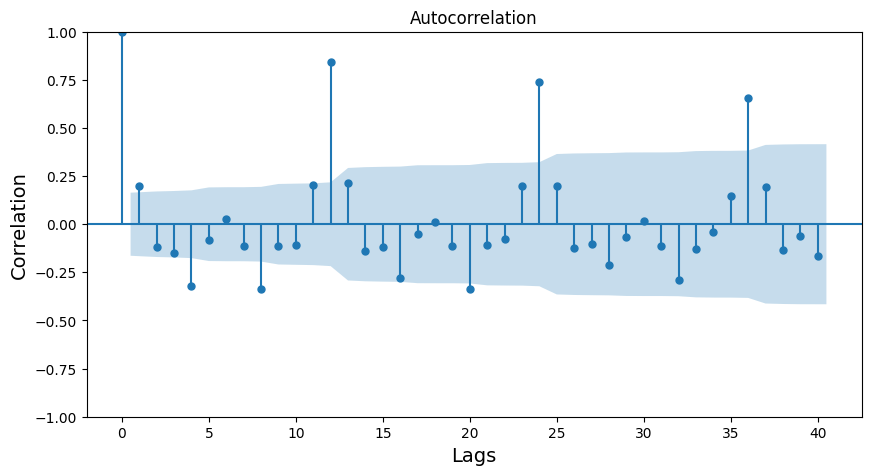

In [190]:
plt.rc("figure", figsize=(10, 5))
plot_acf(diff_log_series, lags = 40)
plt.xlabel('Lags', fontsize = 14)
plt.ylabel('Correlation', fontsize = 14)
plt.show()

In [237]:
from statsmodels.tsa.arima.model import ARIMA

model_ma1 = ARIMA(y, order=(0, 0, 1))
result_ma1 = model_ma1.fit()


NameError: name 'y' is not defined

In [142]:
df.head()

,Passengers,Passenger_Diff,Passenger_log,Passengers_dif_log
Date,,,,
1949-01-01,112,NaN,4.718499,NaN
1949-02-01,118,6.0,4.770685,0.052186
1949-03-01,132,14.0,4.882802,0.112117
1949-04-01,129,-3.0,4.859812,-0.022990
1949-05-01,121,-8.0,4.795791,-0.064022
